# Pre-Photometry before measuring with GALFITM

In [63]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [116]:
img_name = 'nircam6'
img_dir = f'./io/image/{img_name}/'
img_merged_path = img_dir + 'merged.fits'

match_dir = f'./io/match/{img_name}/'
prep_dir = f'./io/prep/{img_name}/'

## Create Source Catalog

In [117]:
from photutils.segmentation import SegmentationImage
from photutils.segmentation import SourceCatalog
from astropy.wcs import WCS
from astropy.table import Table, hstack

In [118]:
with fits.open(img_merged_path) as hdul:
    segm = SegmentationImage(hdul['SEGMAP'].data)
    w = WCS(hdul['MERGED'].header)
    image_merged_conv = hdul['SCI_BKSUB_CONV'].data

Set OBSGEO-B to   -36.864348 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725861996.312 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [119]:
tab_ref_matched_selected = Table.read(match_dir + 'matchlog.csv', format='ascii.csv')
tab_sorted = tab_ref_matched_selected[tab_ref_matched_selected.argsort('label')]
tab_sorted = tab_sorted[tab_sorted['label'] != -1]
tab_sorted

RA,DEC,Seq,label,comment
float64,float64,int64,int64,str40
214.90334111,52.83908694,10209,387,--
214.84532306,52.79940194,35055,1205,--
214.91021194,52.84682611,35114,1622,--
214.89828111,52.83950806,10990,2030,--
214.85173889,52.80803194,11320,2647,--
214.88461,52.83265806,35343,3135,--
214.853215,52.81082306,11682,3332,--
214.91408,52.856145,35490,4196,--
214.83265889,52.798735,12198,4447,--


In [120]:
label_column = np.int64(tab_sorted['label'])
seq_column = np.int64(tab_sorted['Seq'])
segm_matched = segm.copy()
segm_matched.keep_labels(label_column)

# Do photometry in every band with SourceCatalog

In [121]:
import glob
img_path_list = glob.glob(img_dir + 'hlsp*.fits')
img_path_list.sort()
img_path_list

['./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f115w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f150w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f200w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f277w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f356w_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f410m_dr0.5_i2d.fits',
 './io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f444w_dr0.5_i2d.fits']

In [122]:
PIXAR_SR = 2.11539874851881E-14
ZERO_POINT =  -6.10 -2.5 * np.log10(PIXAR_SR)
def flux_to_mag(flux):
    return -2.5 * np.log10(flux) + ZERO_POINT

In [123]:
tab_phot = Table([seq_column], names=['EGS-ID'])
band_list = []
for img_path in img_path_list:
    sci = fits.getdata(img_path, hdu='SCI_BKSUB')
    hdr_pri = fits.getheader(img_path, extname='PRIMARY')
    band = hdr_pri['FILTER'].split(' ')[0]
    key_tab = f'KronPhot_{band}_mag'
    cat_sci = SourceCatalog(sci, segm_matched)   
    flux_list = cat_sci.kron_flux
    mag_list = flux_to_mag(flux_list)
    tab_phot.add_column(mag_list, name=key_tab)

In [124]:
tab_phot.write(prep_dir + 'kronphot.csv', format='ascii.csv', overwrite=True)
tab_phot

EGS-ID,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag
int64,float64,float64,float64,float64,float64,float64,float64
10209,nan,nan,nan,26.033877662936813,26.042176005131434,25.886850998493692,25.998352124305818
35055,27.33206220914366,26.956867760124243,26.82717681606334,26.87995921903548,27.15206226249869,27.408260650806,27.24473857534574
35114,26.846392768314747,26.978514599662724,26.96347651805476,26.849278877186993,27.199924015140706,27.635417003739636,27.561338678064594
10990,26.23722362981526,26.149007860850993,26.045711375431896,25.553754880164576,25.592165788273466,25.587999609213895,25.75931547052963
11320,26.695324092263004,26.530753420893475,26.683423402075462,26.55965667178553,26.82280880823258,26.726698006003723,26.95606108258259
35343,26.93655915367401,26.853757453276184,26.14625372006808,26.816777323084114,27.12586776294501,27.362496906877382,27.71337904190295
11682,26.76266145061266,26.416078635351404,26.44755850523029,26.123653334554955,26.44537629416479,26.833861299808863,26.774234383658722
35490,30.837403901495,31.14325000747558,30.728137084357737,30.682272408515544,29.4404924965869,34.27199688330249,30.213626087341847
12198,26.64021997552714,27.020665439483224,26.84775320984828,26.573474360714055,26.700694189055003,26.721674320310623,26.867217545807037


## Show trends of magnitude variation in different bands

In [125]:
key_phot = ['KronPhot_F115W_mag', 'KronPhot_F150W_mag', 'KronPhot_F200W_mag',
       'KronPhot_F277W_mag', 'KronPhot_F356W_mag', 'KronPhot_F410M_mag',
       'KronPhot_F444W_mag']
phot_list = tab_phot[key_phot]

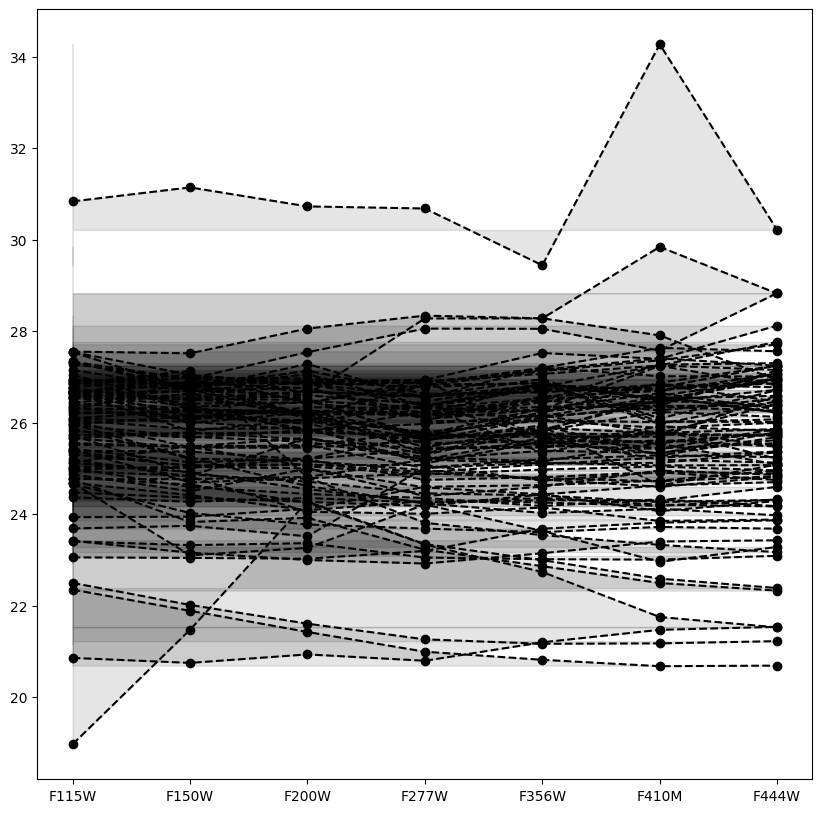

In [126]:
plt.figure(figsize=(10, 10))
for i in range(len(phot_list)):
    bandlabel = [key.replace('KronPhot_','').replace('_mag','') for key in key_phot]
    plt.plot(bandlabel, list(phot_list.as_array()[i]), marker='o', linestyle='--', color='k')
    plt.fill_betweenx(list(phot_list.as_array()[i]), bandlabel, color='k', alpha=0.1)
    plt.savefig(prep_dir + 'kronphot.png')

# Write to FITS file for GALFIT preparation

#### IMGLIST Extension

In [127]:
pregalfit_path = prep_dir + 'pregalfit.fits'

# Create an IMGLIST extension
hdr_img = fits.Header()
hdr_img['EXTNAME'] = 'IMGLIST'

tab_img = Table()
band_list = []
for img_path in img_path_list:
    print(img_path)
    hdr_pri = fits.getheader(img_path, extname='PRIMARY')
    band = hdr_pri['FILTER'].split(' ')[0]
    band_list.append(band)
tab_img.add_columns([band_list,img_path_list], names=['band', 'img_path'])
fits.writeto(pregalfit_path, tab_img.as_array(), header=hdr_img, overwrite=True)

./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f115w_dr0.5_i2d.fits
./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f150w_dr0.5_i2d.fits
./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f200w_dr0.5_i2d.fits
./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f277w_dr0.5_i2d.fits
./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f356w_dr0.5_i2d.fits
./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f410m_dr0.5_i2d.fits
./io/image/nircam6/hlsp_ceers_jwst_nircam_nircam6_f444w_dr0.5_i2d.fits


#### INIPARAM Extension

In [128]:
srccat = SourceCatalog(image_merged_conv, segm_matched, wcs=w, convolved_data=image_merged_conv, progress_bar=True)
srctab = srccat.to_table()
srctab.keep_columns(['label', 'xcentroid', 'ycentroid','orientation','eccentricity'])
kron_rad = srccat.kron_radius*np.sqrt(srccat.semimajor_sigma.value*srccat.semiminor_sigma.value)
srctab.add_column(kron_rad, name='kron_radius')
tab_final = hstack([tab_phot,srctab])
tab_final

kron_radius:   0%|          | 0/91 [00:00<?, ?it/s]

kron_photometry:   0%|          | 0/91 [00:00<?, ?it/s]

EGS-ID,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag,label,xcentroid,ycentroid,orientation,eccentricity,kron_radius
,,,,,,,,,,,deg,,pix
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
10209,nan,nan,nan,26.033877662936813,26.042176005131434,25.886850998493692,25.998352124305818,387,2391.2856446645105,263.92137094586457,39.270681794142355,0.8235859463476308,6.333517159222069
35055,27.33206220914366,26.956867760124243,26.82717681606334,26.87995921903548,27.15206226249869,27.408260650806,27.24473857534574,1205,8741.852667648385,389.9409460016016,-77.99067853237943,0.28883254664019775,5.7762014196644555
35114,26.846392768314747,26.978514599662724,26.96347651805476,26.849278877186993,27.199924015140706,27.635417003739636,27.561338678064594,1622,1359.7701737139391,485.2350234873438,-32.08881599806423,0.6294953413672414,4.816219022625485
10990,26.23722362981526,26.149007860850993,26.045711375431896,25.553754880164576,25.592165788273466,25.587999609213895,25.75931547052963,2030,2591.237911733913,576.6285733045144,-54.499632930054474,0.7030598807318662,6.710729634774058
11320,26.695324092263004,26.530753420893475,26.683423402075462,26.55965667178553,26.82280880823258,26.726698006003723,26.95606108258259,2647,7649.970140235697,705.58532400669,89.75056267716568,0.5412834713953053,5.663720251375023
35343,26.93655915367401,26.853757453276184,26.14625372006808,26.816777323084114,27.12586776294501,27.362496906877382,27.71337904190295,3135,3856.432414799652,802.1401560064679,-55.12054903887198,0.6727406174555017,4.760879086005987
11682,26.76266145061266,26.416078635351404,26.44755850523029,26.123653334554955,26.44537629416479,26.833861299808863,26.774234383658722,3332,7326.484783815408,838.2020857729073,86.15093107393122,0.6627036854133658,7.5297300814117305
35490,30.837403901495,31.14325000747558,30.728137084357737,30.682272408515544,29.4404924965869,34.27199688330249,30.213626087341847,4196,313.7450602000506,989.2597025989149,6.774429900577091,0.7327186659876399,2.8642710856030122


In [129]:
# Create a INIPARAM extension
hdr_ini = fits.Header()
hdr_ini['EXTNAME'] = 'INIPARAM'
fits.append(pregalfit_path, tab_final.as_array(), header=hdr_ini, overwrite=True)

hdr_segm = fits.Header()
hdr_segm['EXTNAME'] = 'SEGMAP'
fits.append(pregalfit_path, segm.data, header=hdr_segm, overwrite=True)

In [130]:
with fits.open(pregalfit_path) as hdul:
    hdul.info()
    print(hdul[3].data)

Filename: ./io/prep/nircam6/pregalfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  IMGLIST       1 BinTableHDU     13   7R x 2C   [5A, 70A]   
  2  INIPARAM      1 BinTableHDU     37   91R x 14C   [K, D, D, D, D, D, D, D, K, D, D, D, D, D]   
  3  SEGMAP        1 ImageHDU         8   (10500, 4800)   int64   


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Test Kron

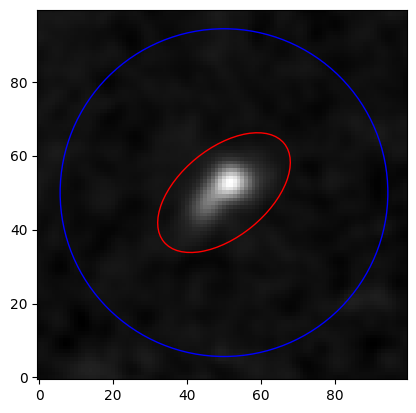

In [131]:
t = srccat.kron_radius
smajor = srccat.semimajor_sigma
sminor = srccat.semiminor_sigma
tx = np.int32(srccat.xcentroid)
ty = np.int32(srccat.ycentroid)
ap = srccat.kron_aperture[0]
ap.positions = [50,50]
import matplotlib.patches as patches

# your existing code
img_cut = image_merged_conv[ty[0]-50:ty[0]+50, tx[0]-50:tx[0]+50]
plt.imshow(img_cut, origin='lower', cmap='gray')
ap.plot(color='red')

# create a circle with radius 20 at position (50, 50)
circle = patches.Circle((50, 50), radius=7*np.sqrt(smajor[0].value*sminor[0].value)*t[0].value, edgecolor='blue', facecolor='none')

# get current axes and add the circle to it
ax = plt.gca()
ax.add_patch(circle)

plt.show()